# Sequential Monte Carlo on a Non-Markovian Gaussian State-Space model

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from jsmc.datagen import non_markovian_gsm as nmgsm
from jsmc.samplers import sequential_monte_carlo as smc

In [3]:
plt.rcParams["figure.figsize"] = [6.4, 4.0]
%config InlineBackend.figure_format = "retina"

## Sampling NM-GSM

In [4]:
key = jax.random.PRNGKey(3141)
key_sample, key_filter = jax.random.split(key)

num_steps = 100
params = nmgsm.ModelParameters(phi=0.0, q=1.0, beta=0.0, r=0.2)
simulation = nmgsm.simulate(key_sample, params, num_steps)

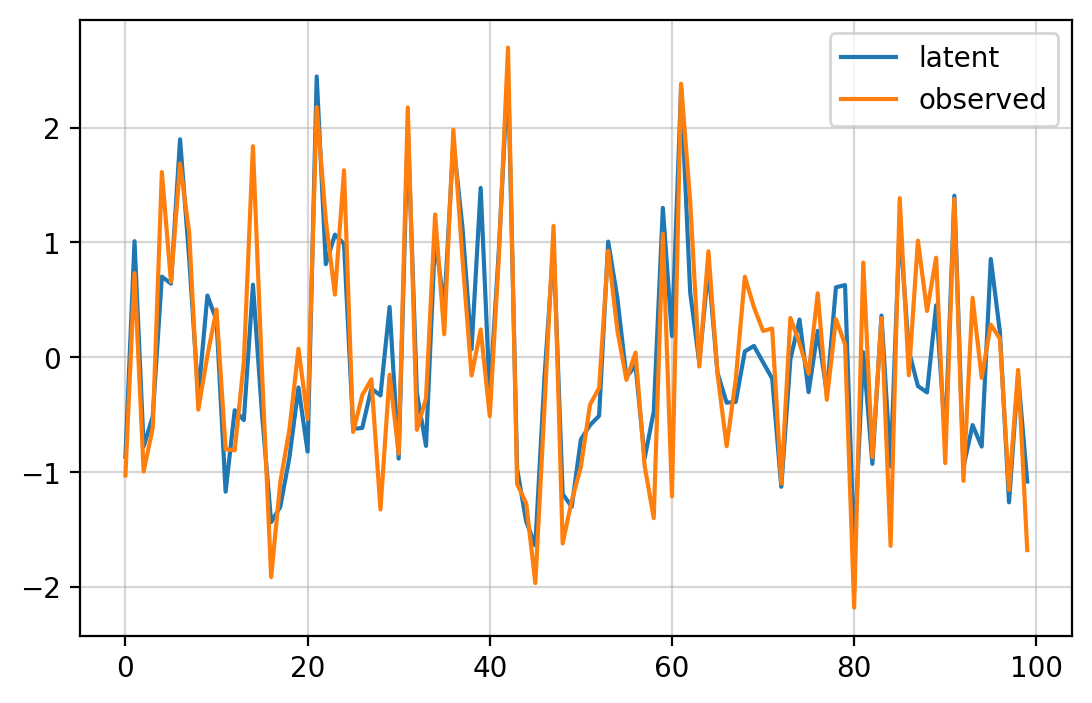

In [5]:
plt.plot(simulation.x, label="latent")
plt.plot(simulation.y, label="observed")
plt.legend()
plt.grid(alpha=0.5)

In [31]:
class BootstrapProposal:
    def __init__(self, params: nmgsm.ModelParameters):
        self.params = params
    
    def get_last_ix(self, state):
        counter = state.vcounter
        ix_min = counter.argmin() 
        return ix_min - 1
    
    def sample(self, key, state: smc.State):
        phi = self.params.phi
        q = self.params.q
        ix_last = self.get_last_ix(state)  
        last_val = state.particles[ix_last]
        
        eps = jax.random.normal(key)
        value = phi * last_val + jnp.sqrt(q) * eps
        return value
    
    def logpdf(self, x, state: smc.State):
        phi = self.params.phi
        q = self.params.q
        
        last_ix = self.get_last_ix(state)
        last_sample = state.particles[last_ix]
        
        dist_norm = distrax.Normal(loc=last_sample * phi, scale=jnp.sqrt(q))
        return dist_norm.log_prob(x)

In [27]:
num_particles = 10
dim_particle = 1

state_init = smc._init_state(num_particles, num_steps, dim_particle)
jax.tree_map(jnp.shape, state_init)

State(particles=(10, 100, 1), log_weights=(10, 100), step=(10,))